#Stroke prediction

##Introduction

###Context, Motivation and Objectives

A stroke occurs when the blood supply to part of the brain is interrupted or reduced, preventing brain tissue from getting enough oxygen and nutrients. As a result, brain cells begin to die within minutes.

The most significant risk factor is high blood pressure. Other major risk factors include obesity, high blood cholesterol, tobacco smoking, diabetes. Some of these risk factors are interrelated, for example, obesity can increase the likelihood of deveoloping both high blood pressure and diabetes.

This medical condition is one of the leading causes of mortality and long-term disability worldwide. For this reason, it is vital to detect it accurately and to identify individuals at risk, so they can take preventive measures to know how to act if a stroke occurs.

The most important metric to evaluate is recall, as it indicates the percentatge of individuals who have experienced a stroke and are correctly identified as positive cases. It is much more critical to avoid classifying a person who will have a stroke as healthy than to incorrectly identify someome without a stroke as at risk.

### Models Theory

The benchmark of this project will be the logistic regression. It is the classic model for binary prediction and serves as a reference to interpret how the predictions of binary reponse works.
The logistic function underlying the regression is based on the logistic distribution, which has two parameters: μ  as a location parameter and s as an scale parameter (usually fixed to 1). To measure the goodness of fit, the log loss derived from the negative log-likelihood is used.


The random forest is an emsemble machine learning method that combines many decision trees. Each tree is trained on a random subset of the training data (sample with replacement) and considers a random subset of features when splitting nodes. For classification, the model predicts the class chosen by the majority of trees. This approach helps reduce overfitting and perfoms well on large and complex datasets.


Gradient boosting is an ensemble learning method that builds a strong predictive model by combining multiple weak learners, typically shallow decision trees. The model is trained iteratively, where each new tree focuses on correcting the errors of the previous trees to minimize a chosen loss function. The learning rate controls how much each tree contributes to the overall model, tuning it properly helps improve accuracy while reducing the risk of overfitting.


Deep learning network is a method with multiple layers between its input (which recieves the data) and output layers (which produces the prediction). The layers in between are deep nets, these refer to the precesence of multiple hidden layers that enable the network learn complex representations.

Each layer consists of multiple nodes that perfom computations on input data.



##Methodology

###Preprocessing
To begin, all variables are visualized to identify any potential data errors. For categorical variables, it is verified that each level represents at least 2% of the total data. Level that do not meet this threshold are removed, as very rare categories add variability and complexity to the models without providing meaningful information.

Secondly, the dataset is checked for duplicate rows, which are removed if found. After that, the variable ID is dropped, as it is not relevant for stroke prediction. It is also important to detect missing data, which will be imputed using the fancyimpute through Multiple Imputation by Chained Equation (MICE). Before performing the imputation, categorical variables must be encoded. Finally, the data before and after imputation are compared to ensure the process was carried out correctly.

To conclude the preprocessing stage, the Mahalanobis distance is used to detect whether there is a high number of outliers in the data, as it is specifically designed to identify multivariate outliers.

###Model Setup and Parameters

To create the logistic regression model, there was a problem because the variable to predict was clearly unbalanced, with many more individual who had not had a stroke. This imbalance makes the model predict only the majority response. For this reason, the dataset was modified using the Smotenc function, which oversamples the minority class and works for datasets containing both numerical and categorical features. After that, since the model was created as a benchmark for evaluation, it was kept as simple as possible, including all the variables without any interactions or modifications.


In the case of the Random Forest and Gradient Boosting models, the approach to addressing the imbalance in the response variable differs from that used in the logistic regression model. When modeling the Random Forest, the RandomForestClassifier module allows the data to be trained as if it was balanced.In contrant, for the Gradient Boosting model, the imbalance problem is handled by increasing the weight of the minority class.
Both models focus on improving the correct prediction of individuals who nave experience an stroke. They are also optimized by training with different parameter combination to identify the setting that achieve the highest recall without overfitting the model. The parameters optimized for the Random Forest include the number of estimators, maximum depth, minimum samples per leaf and split and the maximum number of features.
For the Gradient Boosting model, the parameters tunend include the number of estimators, learning rate, maximum depth, subsample ratio and minimum samples per split.

For the Deep Learning model, the module used was Tensorflow. First of all, it is important to standardize the numerical variables because neural network are sensitive to input scales. Then, as in the Gradient Boosting, the class weights of the response variable were adjusted, so that the minority class level had greater importance. The neural network architecture includes hidden layers with 128->64->32 neurons, and a 0.4 dropout rate is applied to prevent overfitting. The optimizer used is Adam, which is widely popular and efficient. Finally, the model is trained on the entire dataset 25 times (25 epochs), with weights updated after every 32 samples.

In [2]:
from kagglehub import dataset_load, KaggleDatasetAdapter
!pip install -qq fancyimpute --quiet
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from fancyimpute import IterativeImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/stroke-prediction-dataset",
    path="healthcare-dataset-stroke-data.csv"
)

print(df.head(4))

Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   

   stroke  
0       1  
1       1  
2       1  
3       1  


In [5]:
categories=["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status","stroke"]
df[categories] = df[categories].astype("object")

In [6]:
df = df[df['work_type'] != 'Never_worked']
df = df[df['gender'] != 'Other']

The graphics are visualized in appendices.

The levels "never worked" and "other" gender were removed because they represented less than 0.5% of the database. There are other variables with unbalanced levels, such as hypertension and heart disease, but in theses cases, the minority class represents more than 5% and is important for stroke prediction. Furthermore, the BMI includes a few values that are very high. However, this reflects reality, as very few individuals weight 200 kg or more.

In [7]:
print(df.duplicated().sum())

0


There are no duplicated values.

In [8]:
df = df.drop(columns=["id"])

In [9]:
print(df.isna().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


There are missing values only in the BMI variable, and the number of missing entries is relatively small compared to the total number of rows in the dataset.

In [10]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = pd.DataFrame(
    ohe.fit_transform(df[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=df.index
)

df_num = df[num_cols].reset_index(drop=True)
df_combined = pd.concat([df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)], axis=1)

from fancyimpute import IterativeImputer

imputer = IterativeImputer(max_iter=30)
df_imputed_array = imputer.fit_transform(df_combined)

df_imputed = pd.DataFrame(df_imputed_array, columns=df_combined.columns)

import numpy as np

df_final = df_imputed[num_cols].copy()

for i, col in enumerate(cat_cols):
    onehot_cols = [c for c in df_imputed.columns if c.startswith(col + "_")]
    onehot_array = df_imputed[onehot_cols].values

    cat_indices = onehot_array.argmax(axis=1)

    categories = ohe.categories_[i]
    cat_values = np.array([categories[int(x)] for x in cat_indices])

    df_final[col] = cat_values

In [11]:
df_final_imputed_test = df_final.copy()
missing_indices = np.random.choice(df_final_imputed_test.index, size=int(201), replace=False)

df_final_imputed_test.loc[missing_indices,"bmi"]=np.nan

In [12]:
target = 'bmi'

num_cols_imputation = num_cols.difference([target])

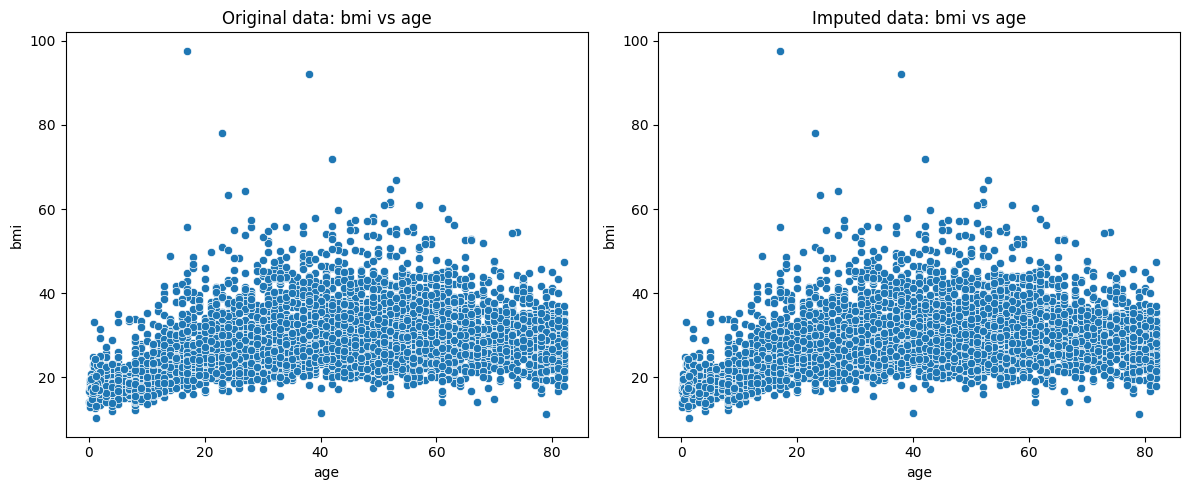

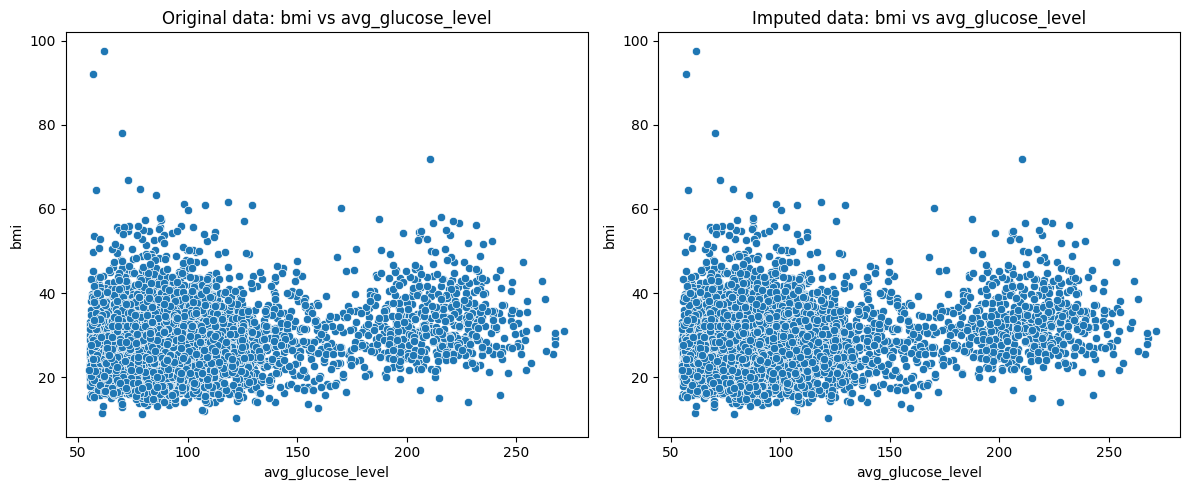

In [13]:
for var in num_cols_imputation:
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=var, y=target)
    plt.title(f'Original data: {target} vs {var}')
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_final_imputed_test, x=var, y=target)
    plt.title(f'Imputed data: {target} vs {var}')

    plt.tight_layout()
    plt.show()




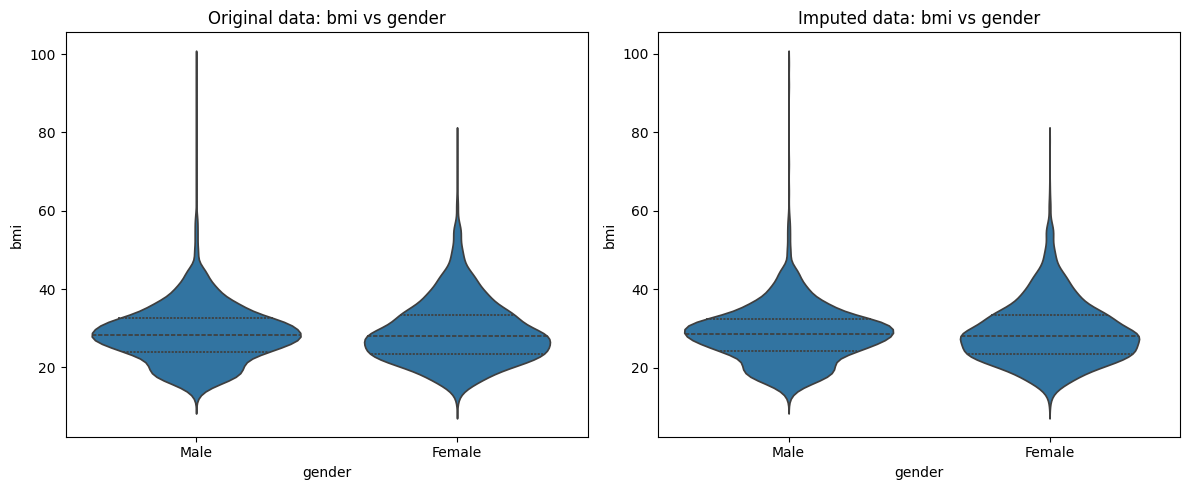

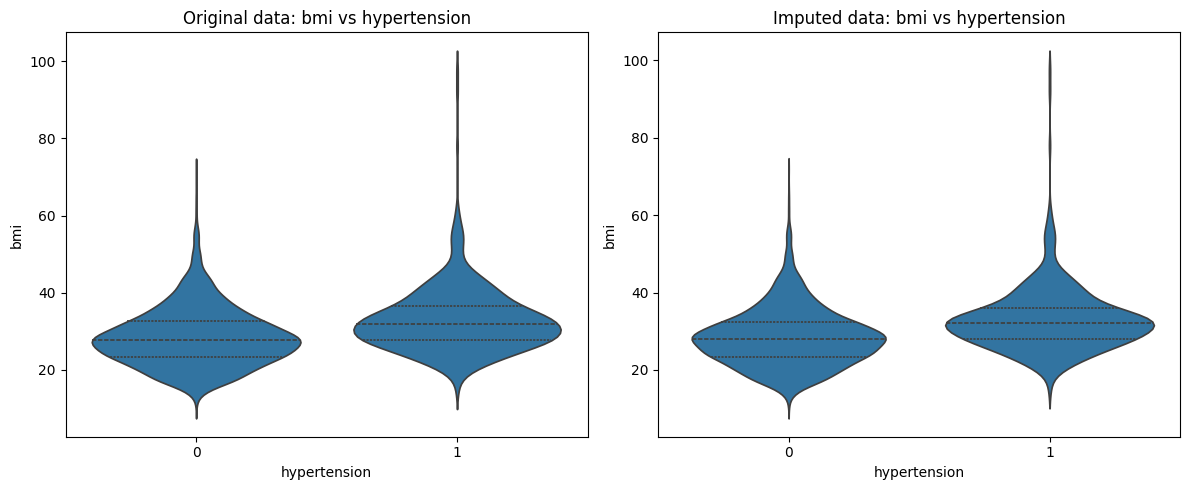

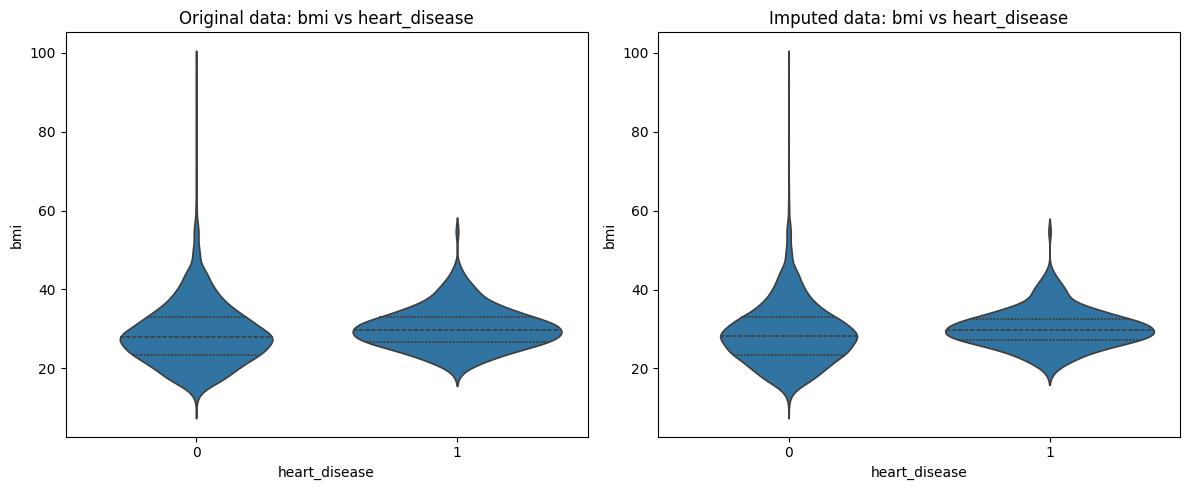

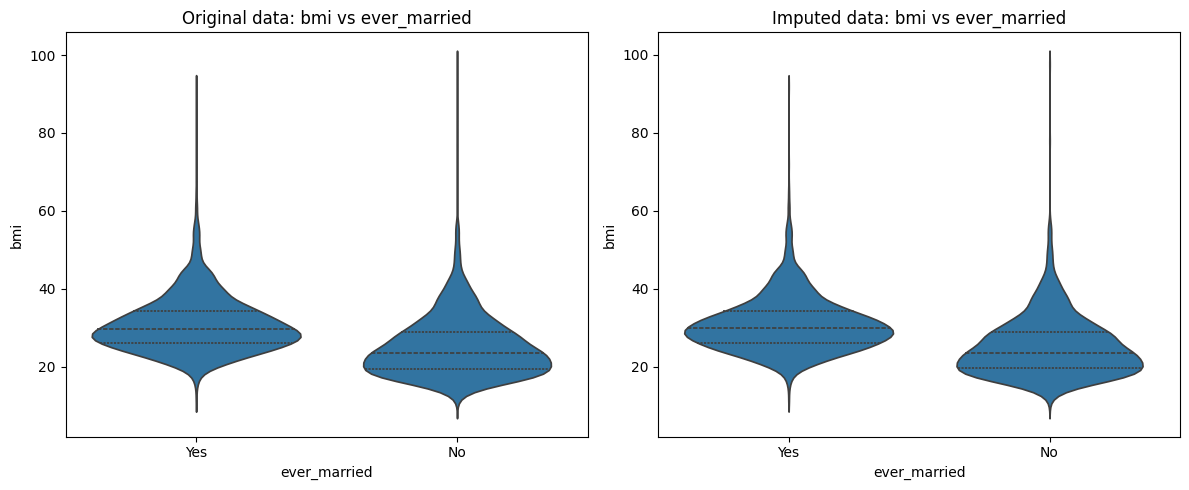

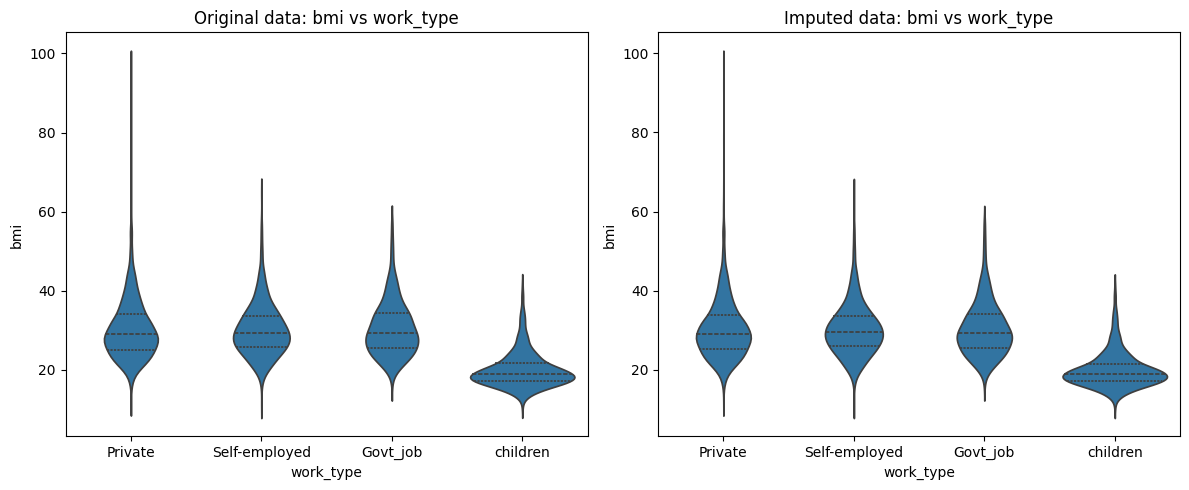

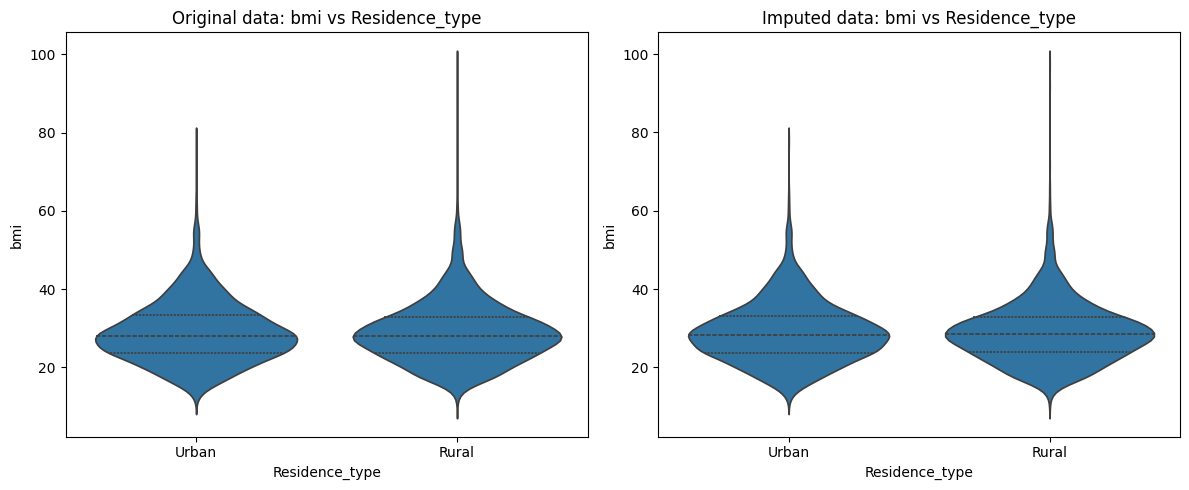

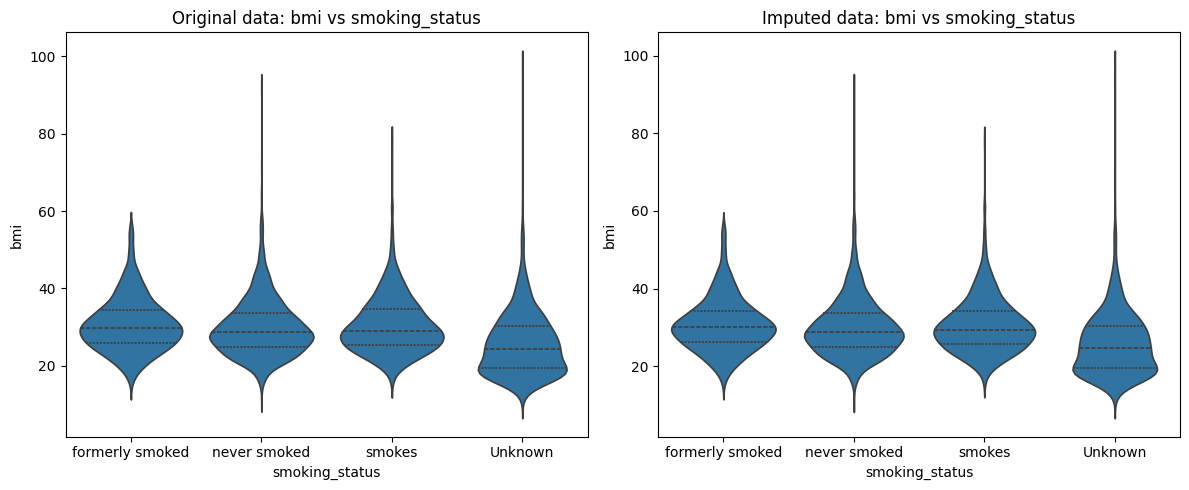

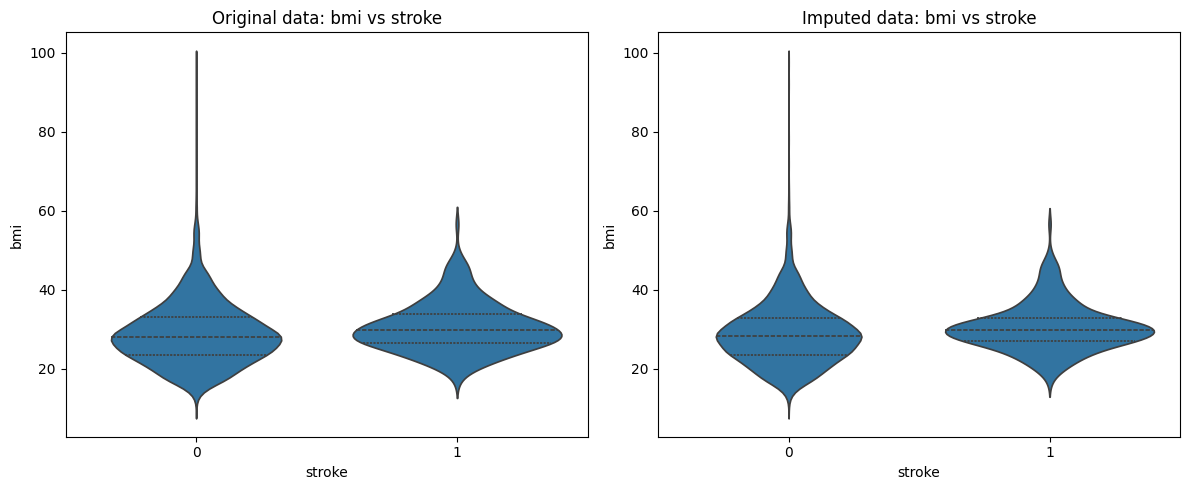

In [14]:
for var in cat_cols:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.violinplot(data=df, x=var, y=target, inner='quartile')
    plt.title(f'Original data: {target} vs {var}')

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df_final_imputed_test, x=var, y=target, inner='quartile')
    plt.title(f'Imputed data: {target} vs {var}')

    plt.tight_layout()
    plt.show()



Through visualization, it is evident that the imputation has preserved the relationship between BMI and other variables. Therefore, the imputation is considered appropiate, and the models will be trained using this imputed dataset.

In [15]:
cov_matrix = np.cov(df_final[num_cols].values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_vec = df_final[num_cols].mean().values

mahalanobis_dist = df_final[num_cols].apply(lambda x: distance.mahalanobis(x, mean_vec, inv_cov_matrix), axis=1)
threshold = np.percentile(mahalanobis_dist, 97.5)
df_outliers = df_final[mahalanobis_dist > threshold]


In [16]:
len(df_outliers)/df_final.shape[0]

0.025162178101041873

Using Mahalanobis distance at the 97.5th percentile as a threshold, approximately 2.5% of the observations were identified as potential multivariate outliers. This is consistent with the expected proportion given the chosen cutoff, suggestig that the dataset constains a small, plausible fraction of atypical cases.

###Logistic Regression

In [17]:
cat_cols = cat_cols.drop("stroke")
y = df_final["stroke"]
X = df_final.drop("stroke", axis=1)

ohe = OneHotEncoder(drop='first', sparse_output=False)

X_cat_encoded = pd.DataFrame(
    ohe.fit_transform(X[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X.index
)

X_num = X[num_cols].reset_index(drop=True)

X_encoded= pd.concat([X_num.reset_index(drop=True), X_cat_encoded.reset_index(drop=True)], axis=1)

X_encoded = sm.add_constant(X_encoded)

categorical_features = [X_encoded.columns.get_loc(col) for col in X_encoded.columns if any(c in col for c in cat_cols)]


X_encoded.columns = X_encoded.columns.str.replace(" ", "_").str.replace("-", "_")

X_train, X_test, y_train, y_test= train_test_split(
    X_encoded, y, test_size=0.33, random_state=42
)

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)


df_smote_train = pd.concat([X_train_smote.reset_index(drop=True), y_train_smote.reset_index(drop=True)], axis=1)



In [18]:
logit_model = smf.logit(
   formula= "stroke ~  age + avg_glucose_level + bmi + C(gender_Male) + C(hypertension_1) + C(heart_disease_1) +  C(ever_married_Yes) + C(work_type_Private) + C(work_type_Self_employed) + C(work_type_children) + C(Residence_type_Urban) + C(smoking_status_formerly_smoked) + C(smoking_status_never_smoked) + C(smoking_status_smokes)",
     data=df_smote_train
     ).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.416883
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 6510
Model:                          Logit   Df Residuals:                     6495
Method:                           MLE   Df Model:                           14
Date:                Sun, 01 Feb 2026   Pseudo R-squ.:                  0.3986
Time:                        17:54:59   Log-Likelihood:                -2713.9
converged:                       True   LL-Null:                       -4512.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -5.5

In [20]:
y_pred_prob = logit_model.predict(X_train)

y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

results_logit = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_logit)


   Accuracy  Precision  Recall      F1
0    0.7714     0.1117  0.5882  0.1877


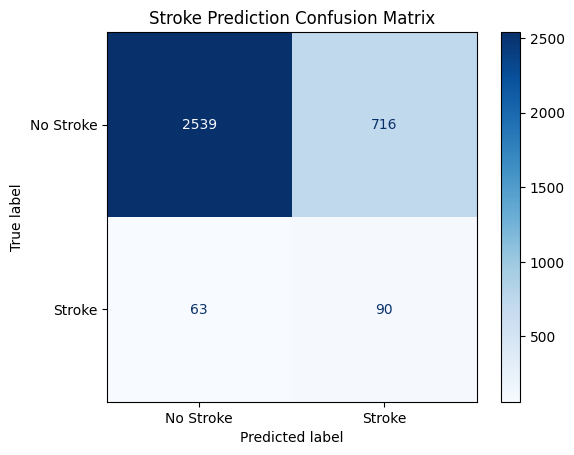

In [21]:
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

In [22]:
y_pred_prob = logit_model.predict(X_test)

y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_logit_test = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_logit_test)


   Accuracy  Precision  Recall      F1
0    0.7695     0.1372  0.5729  0.2213


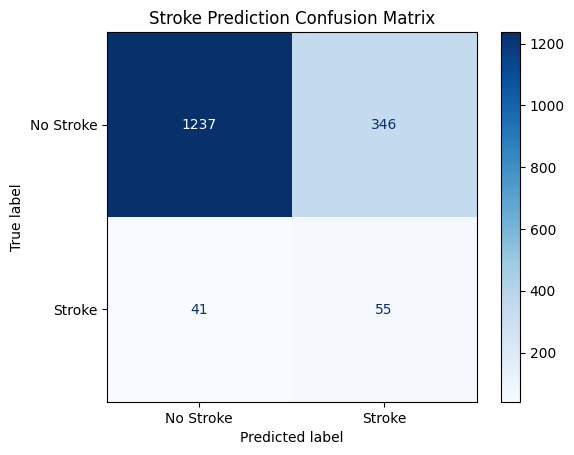

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

The logistic regression has relatively low overall accuracy in detecting the individuals who have experienced a stroke. However, its recall is close to 60%, indicating that whil many stroke cases remain undetected, the majority are correctly identified. Moreover, there is no evidence of overfitting, which makes this model a reliable benchmark for comparison with more complex models.


###Random Forest

In [24]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 5, 6, 7],
    'min_samples_leaf': [5, 8, 10],
    "min_samples_split": [7, 10, 12],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 200}


In [25]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=4,
    min_samples_split=7,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [26]:
accuracy = accuracy_score(y_train, y_pred_rf_train)
precision = precision_score(y_train, y_pred_rf_train)
recall = recall_score(y_train, y_pred_rf_train)
f1 = f1_score(y_train, y_pred_rf_train)

results_rf_train = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_rf_train)

   Accuracy  Precision  Recall     F1
0    0.7174      0.125  0.8824  0.219


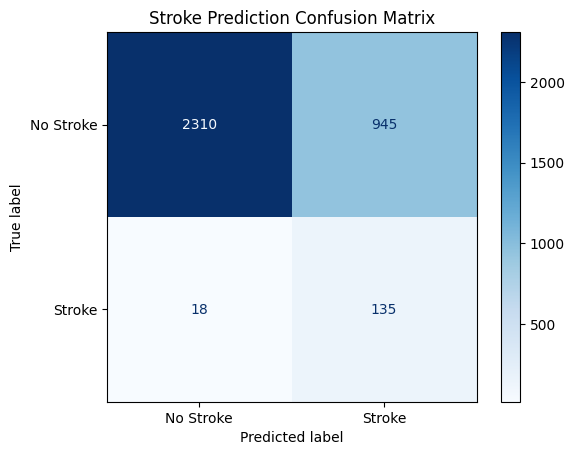

In [27]:
cm = confusion_matrix(y_train, y_pred_rf_train, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

In [28]:
accuracy = accuracy_score(y_test, y_pred_rf_test)
precision = precision_score(y_test, y_pred_rf_test)
recall = recall_score(y_test, y_pred_rf_test)
f1 = f1_score(y_test, y_pred_rf_test)

results_rf_train = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_rf_train)

   Accuracy  Precision  Recall      F1
0     0.729     0.1515  0.8125  0.2553


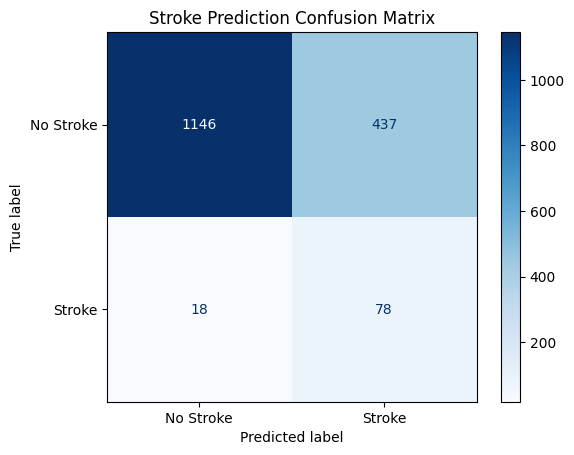

In [29]:
cm = confusion_matrix(y_test, y_pred_rf_test, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

The Random Forest model is much better at predicting individual who have experienced a stroke, with a recall more than 20 percentatge points higher than the benchmark. Although its overall accuracy is slightly lower than that of the benchmark, this is not a major disadvantage. The reduction in accuracy is mainly due to misclassifying individuals who have not experienced a stroke, a much less critical error, since taking preventive measures unnecessarily is far less harmful than failing to take them when a stroke is likely. However, there are minor signs of overfitting in the recall, which is the most important metric in the project.


###Gradient Boosting

In [30]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 3, 5]
}

recall = make_scorer(recall_score)

grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring=recall,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
sample_weights = np.where(y_train == 1, 20, 1)

grid_search.fit(X_train, y_train, sample_weight=sample_weights)

print(grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'learning_rate': 0.01, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [31]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=2,
    subsample=0.8,
    min_samples_split=2,
)

sample_weights = np.where(y_train==1, 20, 1)
gb.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_prob = gb.predict(X_train)
y_train_pred = (y_pred_prob > 0.5).astype(int)

y_pred_prob = gb.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [32]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

results_gradient_train = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_gradient_train)

   Accuracy  Precision  Recall      F1
0    0.6843     0.1119  0.8693  0.1982


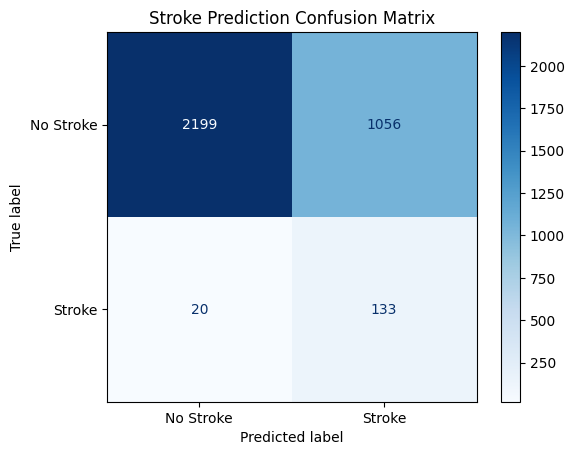

In [33]:
cm = confusion_matrix(y_train, y_train_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

In [34]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_gradient_test = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_gradient_test)

   Accuracy  Precision  Recall      F1
0    0.6992     0.1443  0.8646  0.2474


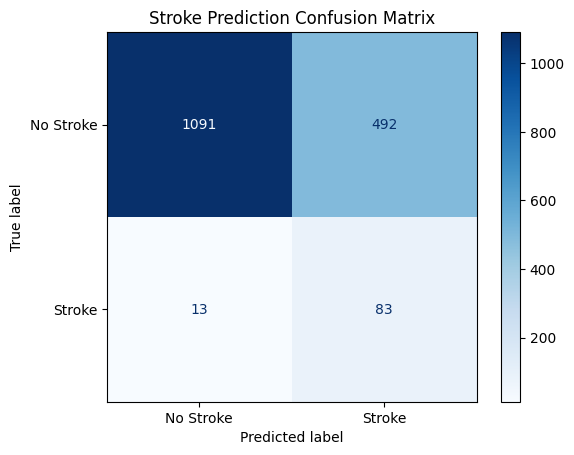

In [35]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

The Gradient Boosting model yield results similar to those of the Random Forest model, though with slightly lower accuracy and recall. Nevertheless, it correctly identifies more than 85% of the individuals who have experienced a stroke, an exceptionally high recall compared to the benchmark. Moreover, the model does not appear to overfit the training data in either overall accuracy or recall, indicating strong robustness and generalization.


###Deep Learning

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Recall(name='recall')
    ]
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    class_weight=class_weights,
    verbose=0,
)


y_pred_prob = model.predict(X_train)
y_train_pred = (y_pred_prob > 0.5).astype(int)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

results_neural_train = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_neural_train)

   Accuracy  Precision  Recall      F1
0    0.7298     0.1293  0.8758  0.2254


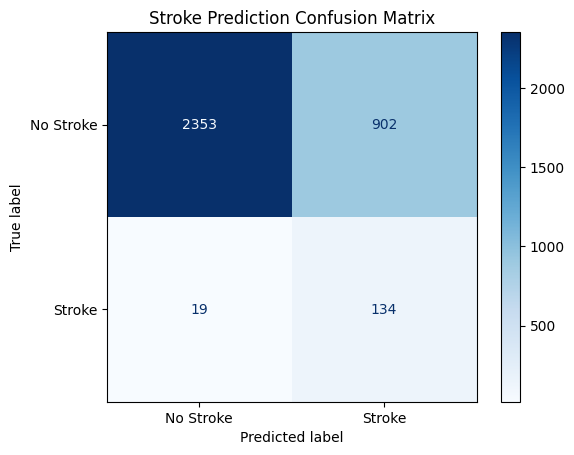

In [38]:
cm = confusion_matrix(y_train, y_train_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

In [39]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results_neural_test = pd.DataFrame({
    "Accuracy": [round(accuracy, 4)],
    "Precision": [round(precision, 4)],
    "Recall": [round(recall, 4)],
    "F1": [round(f1, 4)]
})
print(results_neural_test)

   Accuracy  Precision  Recall      F1
0    0.7391     0.1552  0.8021  0.2601


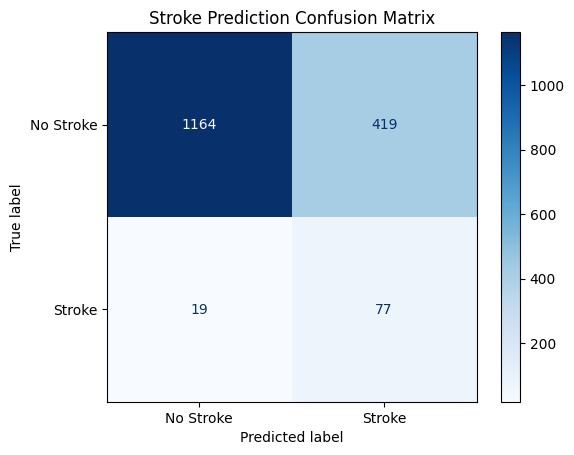

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Stroke Prediction Confusion Matrix')
plt.show()

The Deep Learning  amplifies both the strengths and weaknesses of the Random Forest Model. It achieves the highest recall, making it the most effective at identifying individuals who have experienced a stroke. However, its overall accuracy is lower than that of the Random Forest model and well below the benchmark. Additionally, there are slight signs of overffiting in the recall metric.

##Conclusion

All the models developed have their trade-offs including the benchmark. The logistic regression model achieved the highest overall accuracy rate, but its performance in predicting individuals who have experienced a stroke (who are the  primary focus of this study) was considerably lower. This limitation arise because the classic logistic model lacks straightforward methods to improve the recall.

In contrast, the Random Forest and Deep Learning models showed better results in identifying individuals who have experienced a stroke. They do, however, show slight signs of overfitting in recall, although not in overall accuracy. Since these differences are relatively small, both models are still considered strong and reliable options despite this minor drawback.

The Gradient Boosting model showed the lowest accuracy recall among the machines learning models, but the differences are minimial, less than five percentatge points in both metrics. Importantly, this model was the only machine learning model without signs of overffiting in recall, making it more robust and reliable when applied to new data.

Overall, all machine learning models outperformed the benchmark in identifying individuals who have experienced a stroke, succesfully meeting the project's objective. Nevertheless, because it demonstrated no overfitting and consistent predictive performance, the Gradient Boosting model is considered the best option for stroke prediction, even if its recall and overall accuracy are slightly lower.

##Appendices

###Univariant analysis

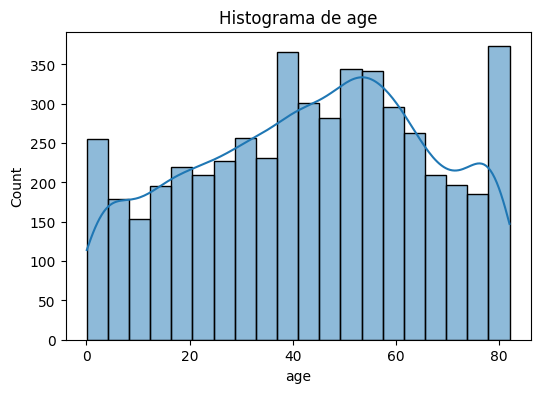

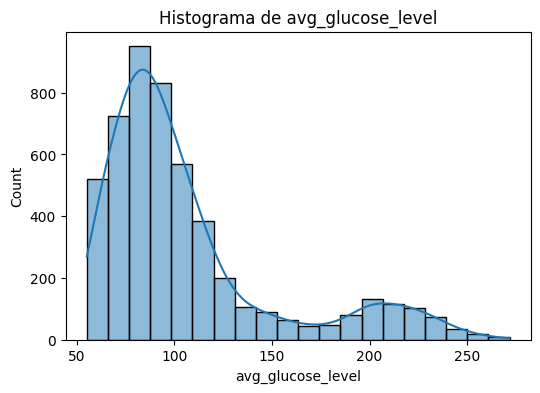

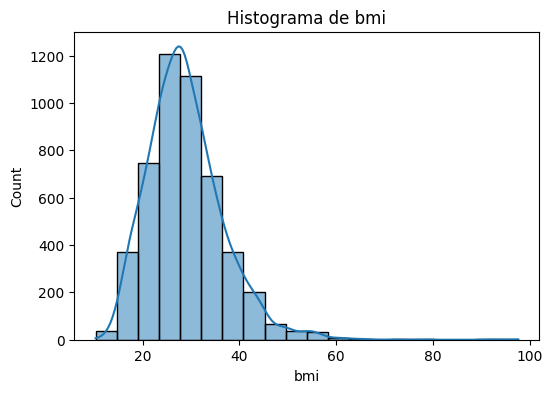

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Histograma de {col}')
    plt.show()

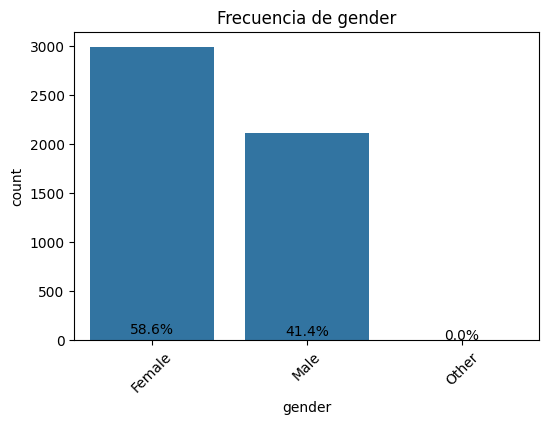

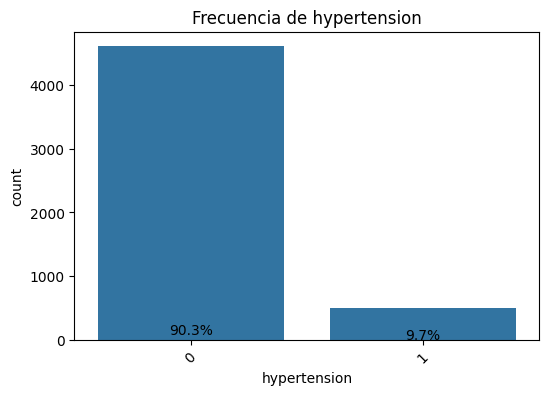

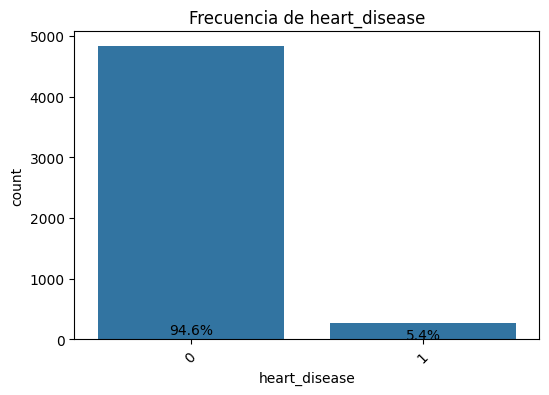

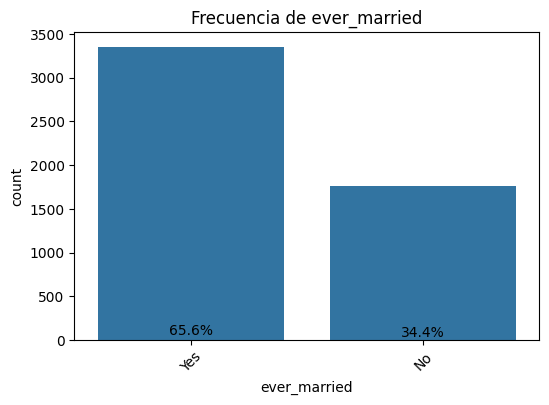

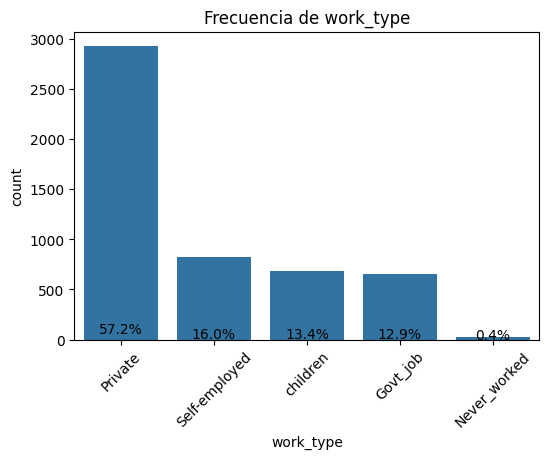

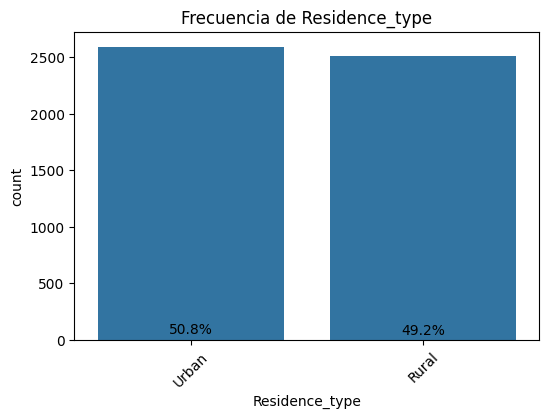

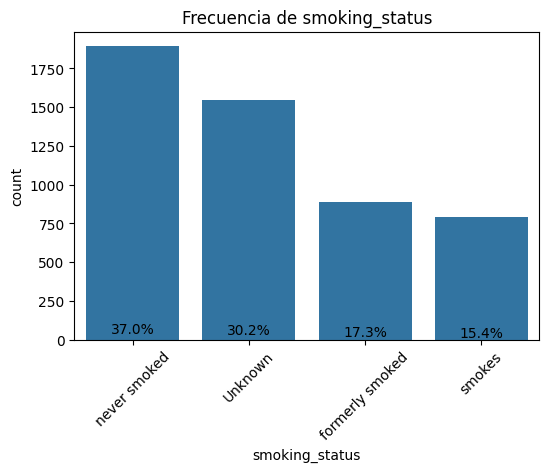

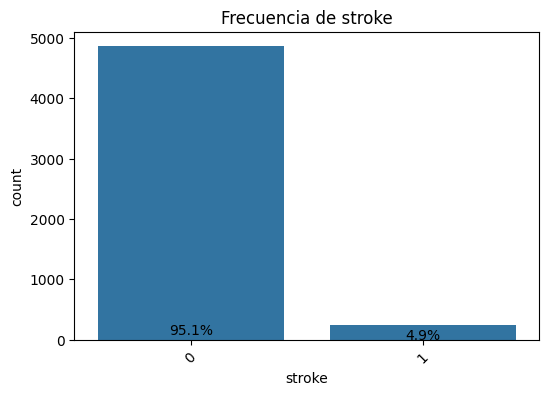

In [ ]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    counts = df[col].value_counts()
    percentages = counts / counts.sum() * 100
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f'Frecuencia de {col}')
    plt.xticks(rotation=45)

    for i, pct in enumerate(percentages):
        plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')

    plt.show()